In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt             
import matplotlib as mpl                    
mpl.rc('font', family='Malgun Gothic')      
plt.rcParams['axes.unicode_minus']=False  

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_validate
from sklearn.metrics import r2_score
import random

import tensorflow as tf
from tensorflow import keras     
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics

from tensorflow.keras.layers import LSTM

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# 전력 예측
- 데이터: https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014
- 날짜와 특정지역코드(MT_001~ MT_370)로 구성
    - 행(Row): 140,256개의 타임스탬프(매 15분 단위)
    - 열(Column): 370개의 소비 지역(전력 미터 ID)
    - 형식: timestamp (DatetimeIndex) + 370개의 소비량 열

## 데이터 전처리

In [4]:
np.random.seed(42)       
tf.random.set_seed(42)   
random.seed(42)

In [5]:
data=pd.read_csv("./Data/LD2011_2014.txt", 
                 sep=";", 
                 index_col=0, 
                 parse_dates=True,  # 날짜처럼 보이는 문자열을 자동으로 datetime
                 decimal=",")
data.shape

(140256, 370)

In [121]:
elec=data.copy()

- 데이터 로드
- 일변 소비량 합산 (평균)
- 평균을 기준으로 High(1)/Low(0) 라벨 생성
- 스케일 조절

In [124]:
# elec.shape
# elec.head(2)
elec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0 MB


In [126]:
# 데이터 리샘플링 (일별 소비량 합산)
daily_elec=elec.resample("D").sum()   # S, T, M, D, W, M, Q, Y
daily_elec.shape

(1462, 370)

In [128]:
# daily_elec.describe()

# 결측치
# daily_data.fillna(method="ffill", inplace=True)

In [130]:
# 임계값 계산 (전체 평균)
threshold=daily_elec.mean(axis=1).mean()
threshold

50704.3933356309

In [132]:
# 새로운 분류 라벨 추가  : 1, 0
daily_elec['label']=np.where(daily_elec.mean(axis=1) > threshold, 1, 0)

In [134]:
daily_elec["label"].value_counts()

label
0    742
1    720
Name: count, dtype: int64

In [136]:
daily_elec.tail()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,label
2014-12-28,227.157360,2131.578947,151.172893,14327.235772,6776.829268,20122.023810,429.621255,25255.892256,5118.881119,4794.623656,...,3272100.0,220721.518987,257477.272727,8169.491525,552.369807,45914.837577,4405.676127,66135.630499,1.553189e+06,1
2014-12-29,248.730964,2212.660028,160.729800,14067.073171,7198.780488,22824.404762,550.593556,30286.195286,6697.552448,6337.634409,...,3109100.0,206852.320675,269090.909091,8438.070404,1153.891164,53928.884987,12914.858097,73882.697947,1.806486e+06,1
2014-12-30,232.233503,2205.547653,165.073849,14290.650407,7189.024390,23880.952381,586.772188,30909.090909,6487.762238,6489.247312,...,2904300.0,204126.582278,263613.636364,10615.384615,892.334699,56334.503951,15996.661102,73950.146628,1.867568e+06,1
2014-12-31,229.695431,2273.115220,166.811468,14006.097561,7023.170732,23511.904762,690.785755,28700.336700,6211.538462,5034.408602,...,2748800.0,162556.962025,215886.363636,7415.906128,530.134582,50259.877085,13245.409015,70416.422287,1.365892e+06,0
2015-01-01,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.175240,249.158249,62.937063,69.892473,...,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7.135135e+03,0


In [190]:
daily_X=daily_elec.drop(['label'], axis=1)
daily_Y=daily_elec['label']
daily_X.shape, daily_Y.shape

((1462, 370), (1462,))

In [192]:
# 정규화
min_max_scaler=MinMaxScaler()
min_max_scaled=min_max_scaler.fit_transform(daily_X)

In [236]:
# 훈련 & 테스트 
X_train, X_test, Y_train, Y_test=train_test_split(min_max_scaled, daily_Y, test_size=0.2, shuffle=False)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1169, 370), (1169,), (293, 370), (293,))

In [196]:
def make_sample(data, labels, seq_length):
    train, target=[], []
    for i in range(len(data) - seq_length):
        train.append(data[i: i+seq_length])        
        target.append(labels[i+seq_length])       
    return np.array(train), np.array(target)

In [198]:
seq_length=30

# 훈련 데이터
X, Y=make_sample(X_train, Y_train.values, seq_length)
X.shape, Y.shape

((1139, 30, 370), (1139,))

In [211]:
train_input, val_input, train_target, val_target=train_test_split(X, Y, test_size=0.2, shuffle=False)
train_input.shape, train_target.shape, val_input.shape, val_target.shape

((911, 30, 370), (911,), (228, 30, 370), (228,))

## LSTM

In [214]:
model=keras.Sequential()
model.add(keras.layers.Input(shape=(seq_length, 370)))                         # LSTM 입력 크기
model.add(keras.layers.LSTM(64, activation='tanh', return_sequences=False))    # 시퀀스 중 마지막 상태만 출력 
model.add(keras.layers.Dense(1, activation='sigmoid'))                         # 출력층
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 64)                  │         111,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,425 (435.25 KB)

 Trainable params: 111,425 (435.25 KB)

 Non-trainable params: 0 (0.00 B)

In [216]:
def on_epoch_end_fun(epoch, logs):  
    if(epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: loss={logs['loss']:.4f}, accuracy={logs['accuracy']:.4f}", 
              f"val_loss={logs['val_loss']:.4f}, val_accuracy={logs['val_accuracy']:.4f}")

        
# 각 에포크가 끝날 때 on_epoch_end 함수
print_callback=LambdaCallback(on_epoch_end=on_epoch_end_fun)

# 학습 중단
early_stopping_callback=EarlyStopping(monitor='val_loss',       
                                      patience=10,                  # epoch 동안 개선이 없으면 학습 중단
                                      verbose=1,                    # early stopping 메시지 출력
                                      restore_best_weights=True)    # 가장 좋은 가중치 복원    

In [218]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [220]:
history=model.fit(train_input, train_target,
                  epochs=100, batch_size=16, verbose=0, 
                  validation_data=(val_input, val_target), shuffle=False, 
                  callbacks=[print_callback, early_stopping_callback])  

Epoch 10: loss=0.4232, accuracy=0.7728 val_loss=0.6673, val_accuracy=0.6711
Epoch 20: loss=0.2551, accuracy=0.9155 val_loss=0.5306, val_accuracy=0.6316
Epoch 30: loss=0.1603, accuracy=0.9429 val_loss=0.7268, val_accuracy=0.6667
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 21.


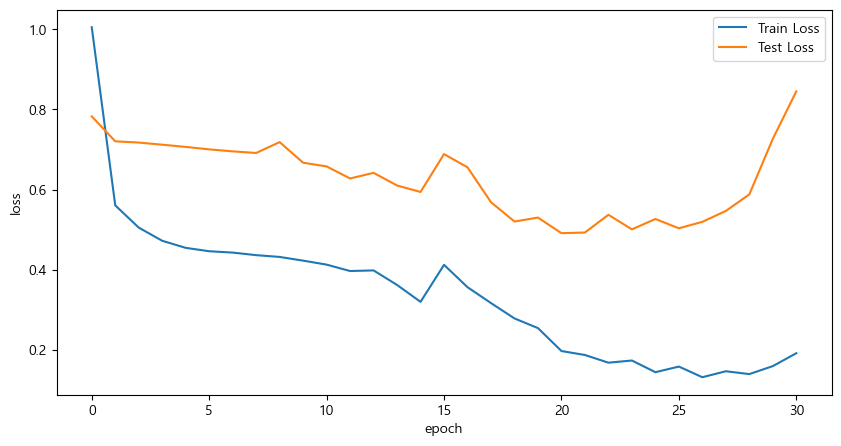

In [222]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [238]:
test_input, test_target=make_sample(X_test, Y_test.values, seq_length)
test_input.shape, test_target.shape

((263, 30, 370), (263,))

In [240]:
test_loss, test_mse=model.evaluate(test_input, test_target)
print(f"Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}")    

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9756 - loss: 0.1717
Test Loss: 0.2149, Test MSE: 0.9468


In [281]:
pred_prob=model.predict(test_input)
pred_prob[0]

pred_class=(pred_prob > 0.5).astype(int)
pred_class[0], test_target[0]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


(array([1]), 1)

In [284]:
metrics.accuracy_score(test_target, pred_class)

0.9467680608365019